In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

# 이미지 노이즈를 제거해 봅시다!!
원본 이미지에 노이즈를 주고 그 노이즈를 제거해 강인한 특징으로 이루어진 이미지를 추출해 봅시다
---

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [3]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다 :",DEVICE)

다음 기기로 학습합니다 : cpu


In [4]:
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw



In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid()
        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr=0.005)
criterion = nn.MSELoss()

In [7]:
#노이즈를 주는 데피니션
def add_noise(img):
    noise = torch.randn(img.size())*0.2
    noisy_img = img + noise
    return noisy_img

In [8]:
def train(autoencoder,train_loader):
    autoencoder.train()
    avg_loss=0
    for step,(x,label) in enumerate(train_loader):
        x = add_noise(x)
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    return avg_loss/len(train_loader)

In [9]:
for epoch in range(1,EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.07868447320770099
[Epoch 2] loss:0.06769950945240094
[Epoch 3] loss:0.06477463501555197
[Epoch 4] loss:0.06399254543361252
[Epoch 5] loss:0.06339426240575974
[Epoch 6] loss:0.06289409911994741
[Epoch 7] loss:0.06260638180047845
[Epoch 8] loss:0.06235863277112751
[Epoch 9] loss:0.062232409371559556
[Epoch 10] loss:0.06208718315100492


In [10]:
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [23]:
#테스트할 데이터를 뽑는 코드!!
sample_data = testset.test_data[1].view(-1,28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

In [24]:
original_x = sample_data[0] #원본 사진
noisy_x = add_noise(original_x).to(DEVICE) #노이즈 사진
_, recovered_x = autoencoder(noisy_x) # 복원 사진

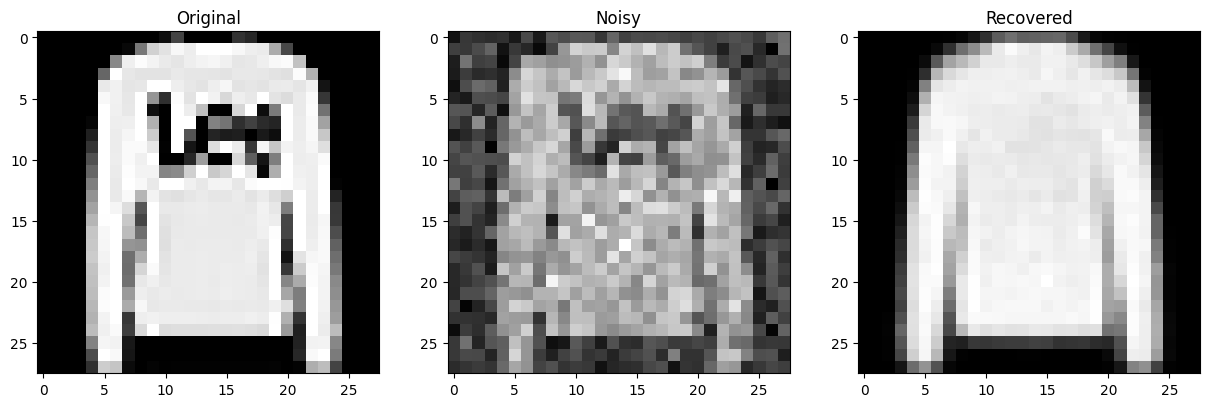

In [25]:
f, a = plt.subplots(1,3,figsize=(15,15))

original_img = np.reshape(original_x.to("cpu").data.numpy(),(28,28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(),(28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(),(28,28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img,cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img,cmap='gray')

plt.show()